<a href="https://colab.research.google.com/github/jmecifu/DiagnosticoPlantasMusaceas/blob/main/DeteccionDePlagasMusaceas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# | Procesamiento de imágenes para la detección de plagas en plantas musáceas

## 1:Importar las Librerías necesarias

In [ ]:
import os
import cv2 
import keras
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



## 2. Importando imágenes

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


### Autenticación de Usuario Google Drive

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive= GoogleDrive(gauth)

### *Trabajando con Archivos Zip*

> Bacterias (1er Dataset)



In [ ]:
bacid = drive.ListFile({'q':"title='Bacterias.zip'"}).GetList()[0]['id']
bac = drive.CreateFile({'id': bacid})
bac.GetContentFile('Bacterias.zip')


In [ ]:
bac.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
!unzip 'Bacterias.zip'

In [ ]:
PATH = '/content/Bacterias'

In [ ]:
os.listdir(PATH)

> Hongos (2do Dataset)

In [ ]:
hoid = drive.ListFile({'q':"title='MFijiensis.zip'"}).GetList()[0]['id']
ho = drive.CreateFile({'id': hoid})
ho.GetContentFile('MFijiensis.zip')



In [ ]:
ho.keys()
!unzip 'MFijiensis.zip'
PATH = '/content/MFijiensis'
#os.listdir(PATH)

> Plantas Saludables (3er Dataset)

In [ ]:
salid = drive.ListFile({'q':"title='Saludables.zip'"}).GetList()[0]['id']
sal = drive.CreateFile({'id': salid})
sal.GetContentFile('Saludables.zip')


In [ ]:
sal.keys()
!unzip 'Saludables.zip'
PATH = '/content/Saludables'
#os.listdir(PATH)

## **3:Preprocesamiento de las Imágenes**

In [ ]:
def Img_preprocessing(n):
    
    #1: Convertir de rgb a escala de grises
    gray_scale=cv2.cvtColor(n, cv2.COLOR_BGR2GRAY )
    
    
    #2: Ajustar la imagen
    img_size=200
    resized_img=cv2.resize(gray_scale,(img_size,img_size)) 
    
    #3: Ecualización de histograma para mejorar el contraste de la imagen
    equ = cv2.equalizeHist(resized_img)
    
    
    #4: remover ruido: utilizando desenfoque gaussiano, para suavizar la imagen
    blur=cv2.medianBlur(equ,5)
    
    #5: Segmentacion de imagen para detectar bordes
  
    grad_x = cv2.Sobel(blur, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(blur, cv2.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    edges = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    clean_data =edges
    return clean_data



dir1= '/content'
catg=['Bacterias', 'MFijiensis', 'Saludables']

img_cube=[]
image_size=800

for i in catg: #Toma las carpetas definidas en ctg
    path=os.path.join(dir1,i)
    label=catg.index(i)
    for j in os.listdir(path): #toma el path actual de cada imagen
        img_arr=cv2.imread(os.path.join(path,j)) #convierte la imagen rgb a escala de grises
        final_data=Img_preprocessing(img_arr)
        img_cube.append([final_data,label])
print("Tamaño del dataset: ",len(img_cube))
print("Whole image data in array format:\n",img_cube[10])

Tamaño del dataset:  2302
Whole image data in array format:
 [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 0]


0

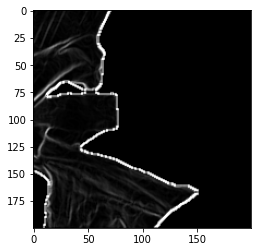

In [ ]:
plt.imshow(img_cube[3][0],cmap='gray')
img_cube[3][1]

0

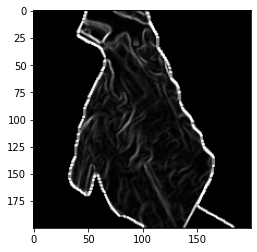

In [ ]:
plt.imshow(img_cube[350][0],cmap='gray')
img_cube[350][1]

In [ ]:
img_cube[350][0].shape

(200, 200)

0

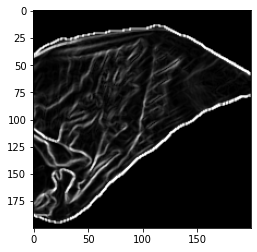

In [ ]:
plt.imshow(img_cube[500][0],cmap='gray')
img_cube[500][1]

In [ ]:

random.shuffle(img_cube)

for i in img_cube[:10]:
    print(i[1])



0
0
2
2
0
2
1
2
0
2


# 3.Implementación del Clasificador

In [ ]:
from sklearn.svm import SVC

feature=[]
target=[]
for i in img_cube:
    flat=i[0].flatten()
    feature.append(flat)
for i in img_cube:
    target.append(i[1])
    
len(feature),len(target)

x_train,x_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,random_state=42)

clf1=SVC().fit(x_train,y_train)
y_pred=clf1.predict(x_test)

print("*-*"*100)
print(accuracy_score(y_test,y_pred)*100)
print("*-*"*100)

feature[10]

*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
69.09722222222221
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

## Matriz de Evaluación


              precision    recall  f1-score   support

         FOC       0.59      0.73      0.65       218
        MFIJ       0.87      0.58      0.69       151
   Saludable       0.74      0.73      0.74       207

    accuracy                           0.69       576
   macro avg       0.73      0.68      0.69       576
weighted avg       0.72      0.69      0.69       576



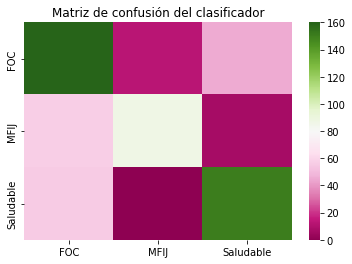

In [ ]:
labels={0:'FOC',1:'MFIJ',2:'Saludable', 3:'Bac'}
plt.title('Matriz de confusión del clasificador')
sns.heatmap(confusion_matrix(y_test,y_pred,),cmap="PiYG", xticklabels=['FOC', 'MFIJ','Saludable'],yticklabels=['FOC', 'MFIJ','Saludable'])

confusion_matrix(y_test,y_pred)
from sklearn.metrics import classification_report
k=classification_report(y_test,y_pred,target_names=['FOC', 'MFIJ','Saludable'])
print(k)

# Comparar fiabilidad sin preprocesamiento de imágenes




In [ ]:
from sklearn.svm import SVC

In [ ]:
dir2="/content"
catg=['Bacterias','MFijiensis','Saludables']

img_cube2=[]
image_size=500

for i in catg:
    path=os.path.join(dir2,i)
    label=catg.index(i)
    for j in os.listdir(path): 
        img_arr=cv2.imread(os.path.join(path,j))
        gray_scale=cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY )
        resized_img=cv2.resize(gray_scale,(200,200))
        img_cube2.append([resized_img,label])

random.shuffle(img_cube2)

feature2=[]
target2=[]
for i in img_cube2:
    flat=i[0].flatten()
    feature2.append(flat)
for i in img_cube2:
    target2.append(i[1])
    
#len(feature2),len(target2)

x_train2,x_test2,y_train2,y_test2=train_test_split(feature2,target2,test_size=0.25,random_state=42)

clf1=SVC().fit(x_train2,y_train2)
y_pred2=clf1.predict(x_test2)

print("*-*"*100)
print(accuracy_score(y_test2,y_pred2)*100)
print("*-*"*100)

feature[10]

*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
68.22916666666666
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


array([ 0, 16, 16, ...,  1,  1,  0], dtype=uint8)

# Comparar fiabilidad con imágenes a Color

In [ ]:
dir2="/content"
catg=['Bacterias','MFijiensis','Saludables']

img_cube2=[]
image_size=500

for i in catg: 
    path=os.path.join(dir2,i)
    label=catg.index(i)
    for j in os.listdir(path): 
        img_arr=cv2.imread(os.path.join(path,j))
        #gray_scale=cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY )
        resized_img=cv2.resize(img_arr,(200,200))
        img_cube2.append([resized_img,label])

random.shuffle(img_cube2)

feature2=[]
target2=[]
for i in img_cube2:
    flat=i[0].flatten()
    feature2.append(flat)
for i in img_cube2:
    target2.append(i[1])
    
#len(feature2),len(target2)
feature2 = np.array(feature2)/ 255.0

x_train2,x_test2,y_train2,y_test2=train_test_split(feature2,target2,test_size=0.25,random_state=42)

clf1=SVC().fit(x_train2,y_train2)
y_pred2=clf1.predict(x_test2)

print("*-*"*100)
print(accuracy_score(y_test2,y_pred2)*100)
print("*-*"*100)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
75.0
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [ ]:
np.asarray(x_train).shape

(1726, 40000)

# Data augmentation

In [ ]:
data_aug=ImageDataGenerator(  rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              channel_shift_range=0.2,
                              zoom_range=0.2,
                              fill_mode="nearest",
                              horizontal_flip=True,
                              vertical_flip=True
                             )         
s=data_aug.flow(x_train, y_train,batch_size = 32)
s[0][0][0]

ValueError: ignored

In [ ]:
# Encontrando imágenes de clase BAC
i=0
for batch in data_aug.flow_from_directory(directory="/content",
                                          classes=['Bacterias'],
                                          batch_size=32,
                                          target_size=(500,500),
                                          color_mode='rgb',
                                          save_to_dir='/content/Bacterias',
                                          save_prefix='aug',
                                          save_format='png'):
    i += 1
    if i>19: #for a particular class it creates 20 image for image in that class
        break

Found 903 images belonging to 1 classes.


In [ ]:
# Encontrando imágenes de clase MFIJ
i=0
for batch in data_aug.flow_from_directory(directory="/content",
                                          classes=['MFijiensis'],
                                          batch_size=32,
                                          target_size=(500,500),
                                          color_mode='rgb',
                                          save_to_dir='/content/MFijiensis',
                                          save_prefix='aug',
                                          save_format='png'):
    i += 1
    if i>19: #for a particular class it creates 20 image for image in that class
        break

Found 584 images belonging to 1 classes.


In [ ]:
#Encontrando imágenes saludables
i=0
for batch in data_aug.flow_from_directory(directory="/content",
                                          classes=['Saludables'],
                                          batch_size=32,
                                          target_size=(500,500),
                                          color_mode='rgb',
                                          save_to_dir='/content/Saludables',
                                          save_prefix='aug',
                                          save_format='png'):
    i += 1
    if i>19: #for a particular class it creates 20 image for image in that class
        break

Found 815 images belonging to 1 classes.


# Extaer los datos

In [ ]:
dir1= '/content'
catg=['Bacterias', 'MFijiensis', 'Saludables']

img_cube3=[]
#image_size=800

for i in catg: 
    path=os.path.join(dir1,i)
    label=catg.index(i)
    for j in os.listdir(path): 
        img_arr=cv2.imread(os.path.join(path,j)) 
        #gray_img=cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY )
        final_data=cv2.resize(img_arr,(100,100))
        img_cube3.append([final_data,label])
        
img_cube3[10]

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

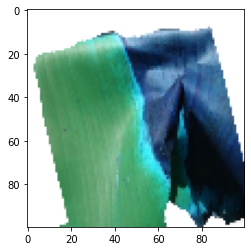

In [ ]:
feat3=[]
tar3=[]
for i,j in img_cube3:
    feat3.append(i)
    tar3.append(j)
x=np.array(feat3)
x=x/255.0 
y=np.array(tar3)
plt.imshow(x[500],cmap='gray')

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.30)
x_train.shape

(2938, 100, 100, 3)

In [ ]:
#y_train=to_categorical(y_train, dtype ="float64")
#y_test=to_categorical(y_test,  dtype ="float64")

In [ ]:
y_test.shape,y_train.shape

((1260,), (2938,))

In [ ]:
x_train.dtype,y_train.dtype

(dtype('float64'), dtype('int64'))

In [ ]:
#x_train2=x_train2.reshape(len(x_train2),200,200,1) #these two lines are not applicable for colored image we can directly fit those values
#x_test2=x_test2.reshape(len(x_test2),200,200,1)

# Data augmentation for a single image

In [ ]:
# example of horizontal shift image augmentation
from numpy import expand_dims

# load the image
img = load_img("/content/Saludables/25.png")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# prepare iterator
it = data_aug.flow(samples, batch_size=9)
# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

NameError: ignored

# Train Neural network model

In [ ]:
cnn2=Sequential()

#convolutional layer-1
cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu',  padding='same'))
cnn2.add(MaxPooling2D(2,2))

#convolutional layer-2
cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu',  padding='same'))
cnn2.add(MaxPooling2D(2,2))

#convolutional layer-3
cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu',  padding='same'))
cnn2.add(MaxPooling2D(2,2))


#convolutional layer-4
cnn2.add(Conv2D(256, kernel_size=(3, 3), activation='relu',  padding='same'))
cnn2.add(MaxPooling2D(2,2))


#flatten layer
cnn2.add(Flatten(input_shape=x_train.shape[1:] ))


cnn2.add(Dense(256,activation='relu'))

#densly connected layer
cnn2.add(Dense(128,activation='relu'))

#output layer
cnn2.add(Dense(3,activation='softmax'))


cnn2.compile(optimizer='Adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
#logit=true when we not use any normalization for last layer that means if we don't apply any act. fun then keep logit=true0----
#with RMSPROP got 74-72%
#SGD found 57%



history2=cnn2.fit(  x_train,
          y_train,
          verbose=1,
          epochs=200,  #20
          batch_size=32,  #15
          validation_data=(x_test,y_test) )

Epoch 1/200
92/92 [==============================] - 18s 45ms/step - loss: 1.0818 - accuracy: 0.3819 - val_loss: 1.0725 - val_accuracy: 0.3468
Epoch 2/200
92/92 [==============================] - 3s 35ms/step - loss: 1.0613 - accuracy: 0.4238 - val_loss: 1.0506 - val_accuracy: 0.4048
Epoch 3/200
92/92 [==============================] - 3s 35ms/step - loss: 1.0315 - accuracy: 0.4894 - val_loss: 1.0191 - val_accuracy: 0.5659
Epoch 4/200
92/92 [==============================] - 3s 35ms/step - loss: 0.9929 - accuracy: 0.5674 - val_loss: 0.9727 - val_accuracy: 0.6040
Epoch 5/200
92/92 [==============================] - 3s 35ms/step - loss: 0.9401 - accuracy: 0.6072 - val_loss: 0.9311 - val_accuracy: 0.6143
Epoch 6/200
92/92 [==============================] - 3s 35ms/step - loss: 0.8966 - accuracy: 0.6181 - val_loss: 0.8926 - val_accuracy: 0.5984
Epoch 7/200
92/92 [==============================] - 3s 35ms/step - loss: 0.8606 - accuracy: 0.6205 - val_loss: 0.8692 - val_accuracy: 0.6135
Epoch

# Observation

>By giving batch size 50 and test size 30% and using optimizer ADAM we found acc 99,86 and loss 0.02,0.60 for training and testing(without using any act. fun in output layer)

>By giving batch size 50 and test size 30% and using SGD as optimizer accuracy found 89,79 and loss found 0.26,0.60(loss for testing flacutating) for training and validation. 

>By using ADAMAX optimizer with 50 epoch accuracy found 100,86 and loss found 0.001 and 0.56(loss of test lies between 0.60 to 0.50) for training and validation.(without using any act. fun in output layer)

>Using Adadelta with 50 epoch accuracy and loss found 55,53(same acc flowing for 20 no of epochs) and 1.02,1.02 (same loss flowing after certain no of epoch)

In [ ]:
# Evaluating the Predictions on the Model

score = cnn2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4405919015407562
Test accuracy: 0.8126984238624573


In [ ]:
y_pred=[]
for i in range(len(x_test)):
        y_pred.append(cnn2.predict(x_test[i].reshape(1,100,100,3)))
        
len(y_test),len(y_pred)

(1260, 1260)

In [ ]:
y_pred[:10]  #to get max probability value we use argmax

[array([[3.8417156e-06, 9.9999583e-01, 3.6779892e-07]], dtype=float32),
 array([[1.062967e-01, 8.937024e-01, 8.673176e-07]], dtype=float32),
 array([[0.8735566 , 0.12516667, 0.00127672]], dtype=float32),
 array([[0.92666376, 0.03670622, 0.03663005]], dtype=float32),
 array([[0.023573  , 0.03225016, 0.94417685]], dtype=float32),
 array([[0.98075324, 0.01373157, 0.00551523]], dtype=float32),
 array([[9.2007107e-01, 7.9927437e-02, 1.5030772e-06]], dtype=float32),
 array([[7.2060651e-03, 3.2653476e-04, 9.9246734e-01]], dtype=float32),
 array([[2.9610943e-03, 6.0210651e-04, 9.9643683e-01]], dtype=float32),
 array([[4.1406485e-01, 5.8579946e-01, 1.3578947e-04]], dtype=float32)]

In [ ]:
result=[]
for i in range(len(x_test)):
    result.append(np.argmax(y_pred[i],axis=1)) #it will take index value for which value is maxiumum of that array
result[:10]

[array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([2]),
 array([0]),
 array([0]),
 array([2]),
 array([2]),
 array([1])]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

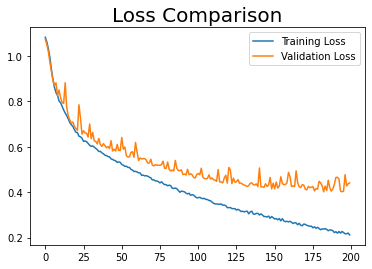

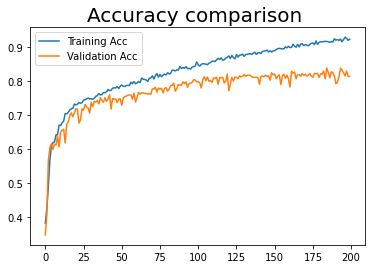

In [ ]:
cnn2.summary()


y_pred2=result

print("*-*"*40)
print("Accuracy Found: ",accuracy_score(y_test,np.array(y_pred2)))
#using adam accuracy was 83%
#using adadelta accuracy was 89%
print("*-*"*40)
print("Confusion Matrix:\n",confusion_matrix(y_test,np.array(y_pred2))) 
print("*-*"*40)
print("Classification Report:\n",classification_report(y_test,np.array(y_pred2)))
print("*-*"*40)

#plt.figure(figsize=(15,9))
plt.title('Loss Comparison',fontsize=20)
plt.plot(history2.history['loss'],)
plt.plot(history2.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()


#plt.figure(figsize=(15,9))
plt.title('Accuracy comparison ',fontsize=20)
plt.plot(history2.history['accuracy'],)
plt.plot(history2.history['val_accuracy'])
plt.legend(['Training Acc','Validation Acc'])
plt.show()

In [ ]:
#pickle and joblib
from keras.models import save_model
from keras.models import load_model
#model.save("Banana_leaf_classification.h5") 


# Save the model
filepath = '/content/Bacterias'
save_model(cnn2, filepath)


cnn2.save("BananaLeaf_classifier.h5")

INFO:tensorflow:Assets written to: /content/Bacterias/assets


In [ ]:
#path=r'C:\Users\sahoo\Desktop\Banana_leaf_disease\Deploy'
cnn2.save("/content/Bacterias/BananaLeaf_classifier.h5")

# Model Testing

In [ ]:
# Load the model
from keras.models import load_model

mymodel = load_model("/content/Bacterias/BananaLeaf_classifier.h5")

In [ ]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
def prediction(result,model): #type of result should be an array
    arr=cv2.resize(result,(100,100))
    y_prediction= mymodel.predict(arr.reshape(1,100,100,3))
    result=np.argmax(y_prediction,axis=1) #take the index value of that array which value is maximum
    if result==0:
        print('It has a disease called Black Bacterial Wilt')
    elif result==1:
        print('It has a disease called Black Sigatoka Disease')
    elif result==2:
        print('Wohh!!! It is a healthy Leaf')
        
prediction(x_test[309],mymodel)

It has a disease called Black Sigatoka Disease


In [ ]:
y_test[309]

1

# Model Deployment

In [ ]:
#In the next folder you can see the deployment for this model

In [ ]:
#deployment is done on myapp.py file 